## This notebook accomponies the video here


In [1]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
def calculate_adjusted_MAEP(y_true, y_hat):
    """
    Calculates the adjusted Mean Absolute Percentage Error (adjustedMAPE) of a forecast.

    Parameters:
    y_true (list or array-like): The true values.
    y_hat (list or array-like): The forecasted values.

    Returns:
    float: The adjusted MAPE.
    """
    y_true = np.array(y_true)
    y_hat = np.array(y_hat)

    denom = np.array(y_true) + np.array(y_hat)
    adjustedmape = 200 * np.mean(np.abs(y_true - y_hat) / denom)
    return adjustedmape

## Data Generating Process

Imagine that the Data Generating Process (DGP) is based on a Gaussian GARCH(1, 1):


$$Z_t \sim \mathcal{N}(0,\,\sigma_{t}^{2})\,.$$
$$\sigma_{t} = a_0 Z_{t-1}^{2} + a_1 \sigma_{t-1}^{2} + a_2$$


and the target variable (i.e., variable to be forecasted) $Y_t$ simply follows

$$Y_t = \mu + Z_t^2$$

Let's code the above DGP.

In [3]:
NUM_DAYS = 183
TEST_INDEX = 153
INITIAL_SIGMA = 1
INITIAL_Z = 0

def simulate_variable_evolution(num_days, initial_sigma, initial_z):
    """
    Simulates the evolution of a random variable over a period of num_days.
    
    Parameters:
    - num_days: int, the number of days to simulate.
    - initial_sigma: float, the initial standard deviation of the random variable.
    - initial_z: float, the initial value of the random variable.
    
    Returns:
    - A tuple containing three lists:
        1. A list of the values of the random variable.
        2. A list of the standard deviations of the random variable.
        3. A list of the days simulated.
    """
    sigmas = [initial_sigma]
    zs = [initial_z]
    days = [0]
    
    for i in range(num_days-1):
        new_sigma = np.sqrt(0.1 * zs[-1]**2 + 0.1 * sigmas[-1] + 0.8)
        new_z = np.random.normal(0, new_sigma)
        new_day = days[-1] + 1

        zs.append(new_z)
        sigmas.append(new_sigma)
        days.append(new_day)
        
    return zs, sigmas, days



In [4]:
z_values, sigma_values, days_simulated = simulate_variable_evolution(NUM_DAYS, INITIAL_SIGMA, INITIAL_Z)

The target variable $Y_t$ is 

$$Y_t = \mu + Z_t^2$$

In [5]:
MU = 1
y_values = [MU + elem**2 for elem in z_values]

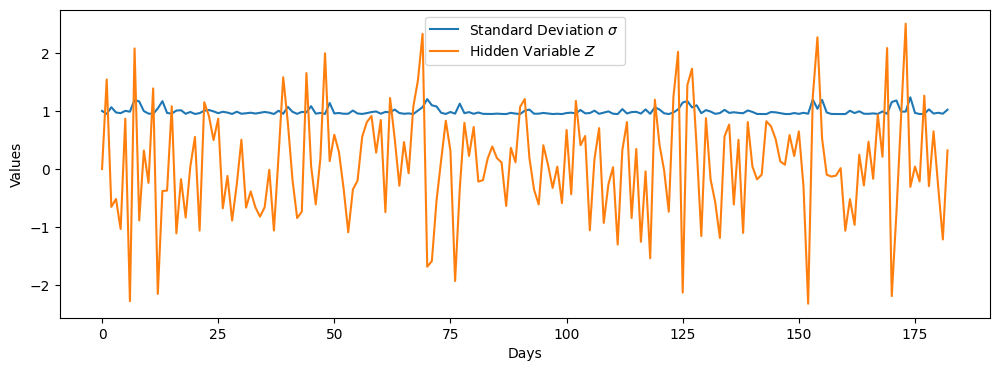

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(days_simulated, sigma_values, label='Standard Deviation $\sigma$')
ax.plot(days_simulated, z_values, label='Hidden Variable $Z$')

ax.set_xlabel('Days')
ax.set_ylabel('Values')

ax.legend()
plt.show()



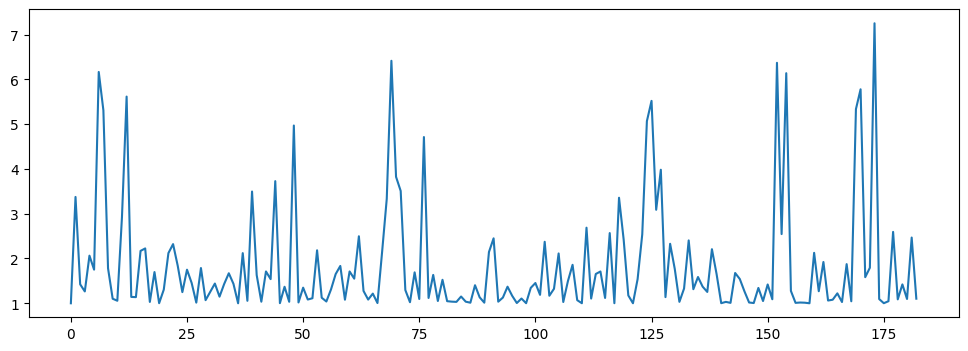

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(days_simulated, y_values, label='True')


Create a dataframe to save days and actual values

In [8]:
df_actual_values = pd.DataFrame({'days': days_simulated, 'actual_values':y_values}, columns=['days','actual_values'])
df_actual_values.to_csv('df_actual_values.csv')

In [9]:
df_actual_values

,days,actual_values
0,0,1.000000
1,1,3.374648
2,2,1.423771
3,3,1.264679
4,4,2.063620
...,...,...
178,178,1.087024
179,179,1.421508
180,180,1.095893
181,181,2.467862


**Expert Forecasts**

Expert submits the conditional expectation of  $Y_t$  at each time as the point forecast for that time. The conditional expectation is obtained as follows. For notational simplicity, it is refered to by $\mathop{\mathbb{E}(Y_t)}$ instead of $\mathop{\mathbb{E}(Y_t\mid t)}$.

$$ \mathop{\mathbb{E}(Y_t)} = \mathop{\mathbb{E}(\mu + Z_t^2)} = \mu + \mathop{\mathbb{E}(Z_t^2)} = \mu + Var(Z_t) + \mathop{\mathbb{E}(Z_t)^2} = \mu + \sigma_t^2$$

where the first three equalities follow simply from the properties of expectation operator and the last equality follows from the fact that $Z_t \sim \mathcal{N}(0,\,\sigma_{t}^{2})\,$ (see above).

In [10]:
# Forecasts
expert_forecasts = [MU + elem**2 for elem in sigma_values[TEST_INDEX:]]

In [11]:
shared_data = y_values[0:TEST_INDEX]
mean_value = sum(shared_data)/len(shared_data)
max_value = max(shared_data)
min_value = min(shared_data)

naive_mean_forecasts = [mean_value] * len(expert_forecasts)
naive_max_forecasts = [max_value] * len(expert_forecasts)
naive_min_forecasts = [min_value] * len(expert_forecasts)

In [12]:
tst_days = [day for day in range(TEST_INDEX, NUM_DAYS)]

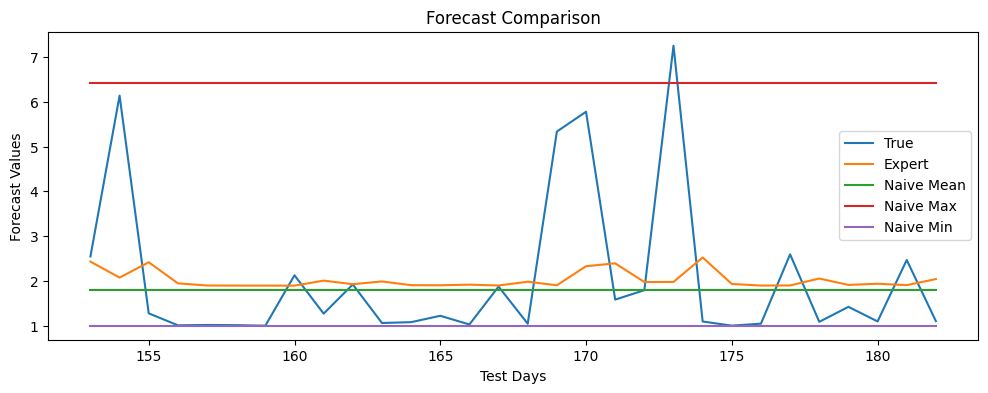

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(tst_days, y_values[TEST_INDEX:], label='True')
plt.plot(tst_days, expert_forecasts, label='Expert')
plt.plot(tst_days, naive_mean_forecasts, label='Naive Mean')
plt.plot(tst_days, naive_max_forecasts, label='Naive Max')
plt.plot(tst_days, naive_min_forecasts, label='Naive Min')

plt.xlabel('Test Days')
plt.ylabel('Forecast Values')
plt.title('Forecast Comparison')

plt.legend()
plt.show()

In [14]:
data = {'tst_days': tst_days,
        'expert': expert_forecasts,
        'naive_mean': naive_mean_forecasts,
        'naive_max': naive_max_forecasts,
        'naive_min': naive_min_forecasts,
        'actual_values': y_values[TEST_INDEX:]
       }

df_forecasts = pd.DataFrame(data)


# write the DataFrame to a CSV file with specific formatting options
df_forecasts.to_csv('df_forecasts.csv', sep='\t', float_format='%.2f')

In [15]:
df_forecasts

,tst_days,expert,naive_mean,naive_max,naive_min,actual_values
0,153,2.432175,1.80485,6.415091,1,2.545541
1,154,2.074228,1.80485,6.415091,1,6.137902
2,155,2.417435,1.80485,6.415091,1,1.276120
3,156,1.946668,1.80485,6.415091,1,1.009496
4,157,1.898246,1.80485,6.415091,1,1.016723
5,158,1.896448,1.80485,6.415091,1,1.012706
6,159,1.895952,1.80485,6.415091,1,1.000272
7,160,1.894682,1.80485,6.415091,1,2.126338
8,161,2.007221,1.80485,6.415091,1,1.269318
9,162,1.927292,1.80485,6.415091,1,1.921786


In [16]:
len(expert_forecasts)

30

In [17]:
# define forecasters and their corresponding forecasts
forecasters = {'expert': expert_forecasts,
               'min': naive_min_forecasts,
               'mean': naive_mean_forecasts,
               'max': naive_max_forecasts}

# initialize errors dataframe
errors = pd.DataFrame(index=['expert', 'min', 'mean', 'max'], columns=['MAE', 'MSE', 'MAPE', 'adjustedMAPE'])

# calculate errors for each forecaster
for forecaster, forecast_values in forecasters.items():
    Y_forecast = forecast_values
    Y_true = y_values[TEST_INDEX:]

    # calculate errors
    MSE = mean_squared_error(Y_true, Y_forecast)
    MAE = mean_absolute_error(Y_true, Y_forecast)
    MAPE = mean_absolute_percentage_error(Y_true, Y_forecast)
    adjustedMAPE = calculate_adjusted_MAEP(Y_true, Y_forecast)

    # save errors to errors dataframe
    errors.loc[forecaster, 'MSE'] = MSE
    errors.loc[forecaster, 'MAE'] = MAE
    errors.loc[forecaster, 'MAPE'] = MAPE
    errors.loc[forecaster, 'adjustedMAPE'] = adjustedMAPE

In [18]:
errors.to_csv('df_errors.csv')

<AxesSubplot: >

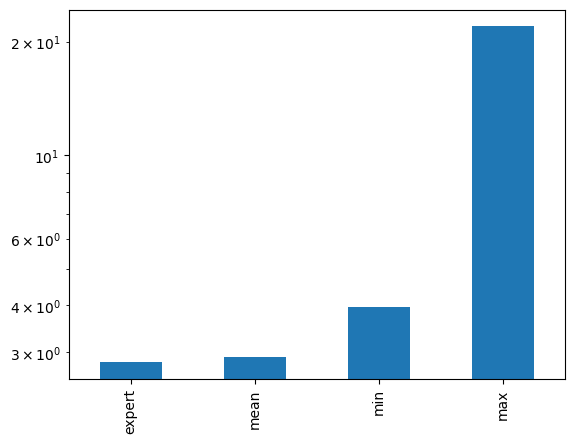

In [19]:
errors.sort_values(by=['MSE'])['MSE'].plot.bar(logy=True)

<AxesSubplot: >

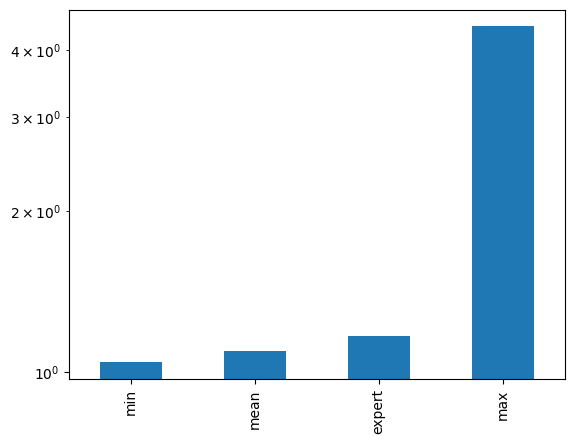

In [20]:
errors.sort_values(by=['MAE'])['MAE'].plot.bar(logy=True)

In [21]:
errors.sort_values(by=['MAPE'])['MAPE']


min       0.299354
mean       0.52586
expert    0.627023
max       3.502406
Name: MAPE, dtype: object

<AxesSubplot: >

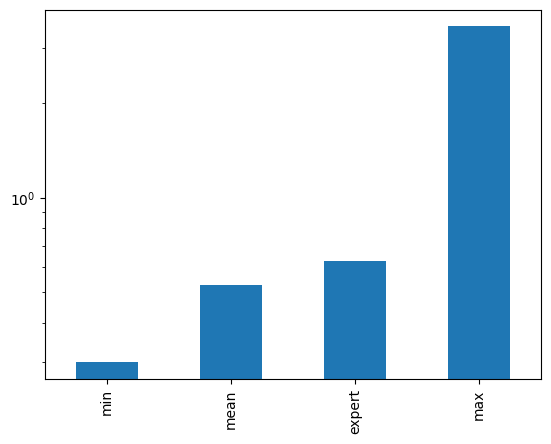

In [22]:
errors.sort_values(by=['MAPE'])['MAPE'].plot.bar(logy=True)

<AxesSubplot: >

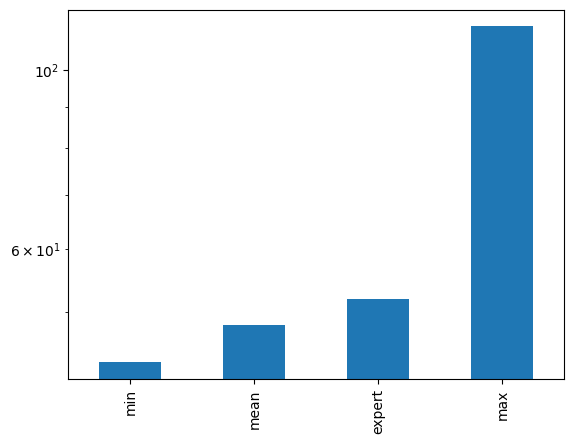

In [23]:
errors.sort_values(by=['adjustedMAPE'])['adjustedMAPE'].plot.bar(logy=True)

In [24]:
errors

,MAE,MSE,MAPE,adjustedMAPE
expert,1.167801,2.824609,0.627023,51.995723
min,1.042679,3.949865,0.299354,43.337356
mean,1.094628,2.919249,0.52586,48.279175
max,4.428258,21.980677,3.502406,113.371189
